<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/main/04%20Deep%20Learning/notebooks/10-LSTM-Clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Long Short-Term Memory Networks: Sentiment Analysis</h1>

En esta notebook usaremos redes LSTM para análisis de sentimientos. Estudiaremos el dataset de reviews de películas de IMDB. Este es un dataset muy usado para tareas de análisis de sentimientos.

En esta tarea no nos interesa tener una salida en cada elemento de la secuencia, solamente queremos la salida al final de la secuencia.


<img align="left" width="50%" src="https://github.com/DCDPUAEM/DCDP/blob/main/04%20Deep%20Learning/img/LSTM.png?raw=1"/>

In [1]:
import tensorflow as tf

print('GPU presente en: {}'.format(tf.test.gpu_device_name()))

GPU presente en: /device:GPU:0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import re
import numpy as np


import keras
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
import nltk

# LSTM for Sentiment Analysis

## El conjunto de datos

IMDB

* Original source: http://ai.stanford.edu/~amaas/data/sentiment/
* Kaggle: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Bajamos este archivo desde Drive. En caso de tener problemas con el siguiente comando, puedes bajar el archivo de [aquí](https://drive.google.com/uc?id=1TewLD3BbgqV1t2I905Al3vm_VqUzoPzg) y luego subirlo manualmente a Colab.

In [4]:
!pip install -q gdown

In [5]:
!gdown 1TewLD3BbgqV1t2I905Al3vm_VqUzoPzg

Downloading...
From: https://drive.google.com/uc?id=1TewLD3BbgqV1t2I905Al3vm_VqUzoPzg
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:03<00:00, 17.7MB/s]


Leemos el dataframe

In [6]:
import pandas as pd

df = pd.read_csv('/content/IMDB Dataset.csv')
display(df)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Tenemos dos clases. Es un problema de clasificación binaria

In [7]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

Las clases están balanceadas

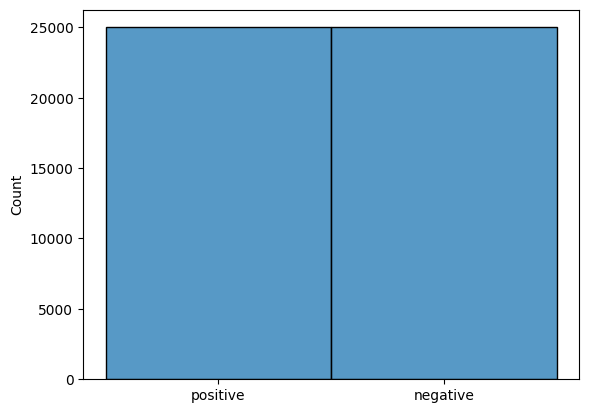

In [8]:
import seaborn as sns

sns.histplot(df['sentiment'].values)
plt.show()

In [9]:
from sklearn.preprocessing import LabelEncoder

labels = df['sentiment'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [10]:
print(f"Before encoding {labels[:3]}")
print(f"After encoding {encoded_labels[:3]}")

Before encoding ['positive' 'positive' 'positive']
After encoding [1 1 1]


## Limpiar texto

In [11]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Limpiamos quitando stopwords, símbolos, tags HTML, etc usando herramientas del módulo `nltk`. Para hacer la limpieza también usamos expresiones regulares *regex*. Puedes practicar el uso de expresiones regulares [aquí](https://regex101.com/).

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def clean(text):
    clean_text = re.sub(CLEANR, '', text.lower()) # Quitamos etiquetas HTML
    clean_text = re.sub(r'[^\w\s]', '', clean_text.lower()) # Quitamos signos de puntuación y símbolos
    clean_text = re.sub('[0-9]', '', clean_text.lower())  # Quitamos números
    SW = stopwords.words('english') # Leemos la lista de stopwords del inglés
    tokens_no_sw = [word for word in word_tokenize(clean_text) if not word in SW] # Quitamos stopwords
    stems = ""
    for w in tokens_no_sw:
        stems += lemmatizer.lemmatize(w) + " "
    return stems

Aplicamos la función de limpieza, tarda alrededor de 1 minuto

In [13]:
df['clean'] = df['review'].apply(clean)
df

,review,sentiment,clean
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...
...,...,...,...
49995,I thought this movie did a down right good job...,positive,thought movie right good job wasnt creative or...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic direc...
49997,I am a Catholic taught in parochial elementary...,negative,catholic taught parochial elementary school nu...
49998,I'm going to have to disagree with the previou...,negative,im going disagree previous comment side maltin...


In [14]:
reviews = df['clean'].values

Separamos en entrenamiento y prueba

In [15]:
from sklearn.model_selection import train_test_split

train_reviews, test_reviews, train_labels, test_labels = train_test_split(reviews, encoded_labels, train_size=0.8)#, stratify = encoded_labels)}}

print(f"Shape of X_train: {train_reviews.shape}")
print(f"Shape of X_test: {test_reviews.shape}")

Shape of X_train: (40000,)
Shape of X_test: (10000,)


Preparamos los reviews. Este proceso consta de dos partes:

1. Vectorización: La clase `Tokenizer` de `keras` permite vectorizar un corpus de textos, convirtiendo cada texto en una secuencia de índices (cada índice representa un token en un diccionario, los índices son $1,...,n$). No se toman en cuenta todas las palabras del vocabulario, se toman solamente las `vocab_size` más frecuentes.

2. Padding: Las secuencias de índices tienen diferentes longitudes, dependiendo de la longitud del review. Las hacemos todas del mismo tamaño de acuerdo a dos criterios:

    * Si la secuencia es más corta que el tamaño especificado, añadimos ceros al final de la secuencia.
    * Si la secuencia es más larga que el tamaño especificado, truncamos la secuencia.


---

**Importante**: Observa que el tokenizador se entrena con los textos de entrenamiento solamente. Después las secuencias de prueba se generan con este tokenizador.

⭕ ¿Qué consecuencias tiene esto?



In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ----- Hiperparámetros para este preprocesamiento
vocab_size = 3000   # Nos limitaremos a ese número de palabras del vocabulario
oov_tok = ''        # Las palabras fuera del vocabulario se reemplazarán con este string
max_length = 200    # La longitud común deseada para las secuencias al hacer el padding

#  ----- Entrenamos el tokenizador
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_reviews)

#  ----- Creamos las secuencias de entrenamiento y hacemos el padding
train_sequences = tokenizer.texts_to_sequences(train_reviews)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)

#  ----- Creamos las secuencias de prueba y hacemos el padding
test_sequences = tokenizer.texts_to_sequences(test_reviews)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

Veamos un ejemplo de cómo se ven las secuencias.

In [17]:
print(f"NL review:\n{train_reviews[0]}\n")
print(f"Sequence:\n{train_sequences[0]}\n")
print(f"Padded Sequence:\n{train_padded[0]}\n")

NL review:
film exceeded expectation thought heard going rubbish wasnt expecting much however pleasantly surprised first didnt take well lead girl didnt really care lived died definitely grew became likable character slasher film people die reason background story take second film explains lot would recommend film everyone youre sure watch anyway hour half life youre going live year anyway 

Sequence:
[3, 1, 1134, 97, 432, 78, 1815, 189, 859, 17, 113, 1, 624, 23, 70, 51, 18, 217, 84, 70, 15, 301, 1237, 908, 302, 1835, 753, 1351, 8, 1044, 3, 19, 660, 146, 713, 10, 51, 204, 3, 2343, 61, 12, 265, 3, 207, 231, 158, 34, 549, 222, 251, 31, 231, 78, 328, 48, 549]

Padded Sequence:
[   3    1 1134   97  432   78 1815  189  859   17  113    1  624   23
   70   51   18  217   84   70   15  301 1237  908  302 1835  753 1351
    8 1044    3   19  660  146  713   10   51  204    3 2343   61   12
  265    3  207  231  158   34  549  222  251   31  231   78  328   48
  549    0    0    0    0    0   

Definimos la arquitectura del modelo.

Observa la capa `Embedding` ([documentación](https://keras.io/api/layers/core_layers/embedding/)). Esta capa se encarga de asignar representaciones vectoriales (embeddings) a cada palabra, lo hace de manera implícita durante el entrenamiento. Otra alternativa es pasar directamente los embeddings pre-entrenados de palabras generados por *word2vec*, *FastText*, *GloVe*, etc.

Definimos la dimensión de los embeddings.

In [18]:
embedding_dim = 100

Construimos el modelo de red neuronal para esta tarea de clasificación. La red consiste de las siguientes partes:

1. Capa de Embedding. Esta capa *traduce* las secuencias de índices a representaciones vectoriales densas de menor dimensión `embedding_dim`. Le especificamos el tamaño de las secuencias y el número de palabras del vocabulario.
2. Célula de LSTM. Esta es la capa recurrente que irá recibiendo secuencialmente las palabras, una a una, de cada review y al final de la secuencia producirá una salida que irá a la siguiente capa.
3. Red MLP. En esta parte de la red hay una red *fully connected* con capas densas.
4. Capa de salida. Dado que es una clasificación binaria, al final tenemos una capa densa de 1 neurona prediciendo la probabilidad de que el review sea positivo. Dado que es una clasificación binaria, usamos la perdida `binary_crossentropy` y además, la métrica `accuracy`.

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM

# ----- model initialization
model = keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(100, dropout=0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# ----- compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          300000    
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 382033 (1.46 MB)
Trainable params: 382033 (1.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Creamos un callback `EarlyStopping` para parar el entrenamiento de la red cuando la pérdida de validación empiece a aumentar. Observa el parámetro `patience`.

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

Entrenamos el modelo, este entrenamiento tarda alrededor de 6 minutos

In [21]:
num_epochs = 20

history = model.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1,
                    validation_split=0.1,
                    callbacks=[es])

Epoch 1/20
1125/1125 [==============================] - 158s 134ms/step - loss: 0.6887 - accuracy: 0.5224 - val_loss: 0.6907 - val_accuracy: 0.4940
Epoch 2/20
1125/1125 [==============================] - 46s 41ms/step - loss: 0.5635 - accuracy: 0.6820 - val_loss: 0.3694 - val_accuracy: 0.8438
Epoch 3/20
1125/1125 [==============================] - 38s 34ms/step - loss: 0.3087 - accuracy: 0.8716 - val_loss: 0.3125 - val_accuracy: 0.8708
Epoch 4/20
1125/1125 [==============================] - 39s 35ms/step - loss: 0.2599 - accuracy: 0.8962 - val_loss: 0.3141 - val_accuracy: 0.8683
Epoch 5/20
1125/1125 [==============================] - 39s 35ms/step - loss: 0.2289 - accuracy: 0.9121 - val_loss: 0.3263 - val_accuracy: 0.8690
Epoch 5: early stopping


Veamos las curvas de entrenamiento

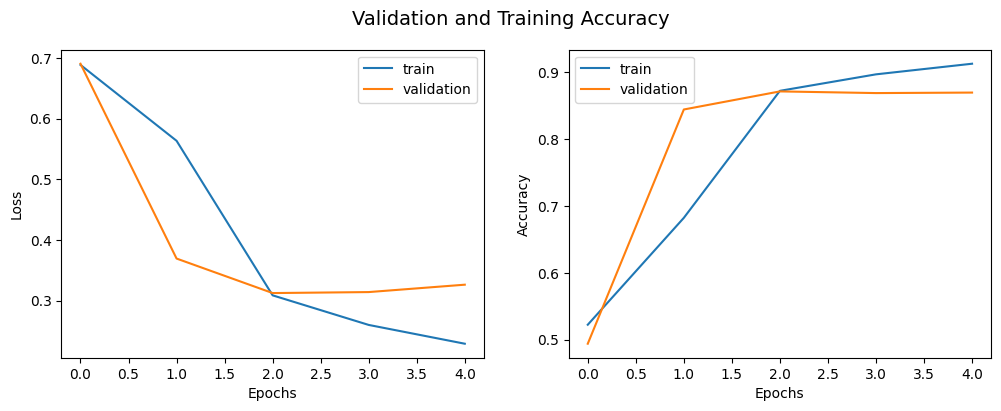

In [22]:
plt.figure(figsize=(12, 4),dpi=100)
plt.suptitle("Training Curves",fontsize=16)
plt.subplot(1, 2, 1)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.subplot(1, 2, 2)
plt.suptitle("Validation and Training Accuracy",fontsize=14)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

## Obtenemos las predicciones y evaluamos el desempeño de la red

¿Cómo se ven las predicciones?

In [23]:
predictions = model.predict(test_padded)

print(predictions[:5])

313/313 [==============================] - 2s 5ms/step
[[0.32623193]
 [0.51860046]
 [0.38870212]
 [0.9724992 ]
 [0.15194389]]


Como podemos ver, la predicción de la red LSTM para cada review es un valor $0 \leq x \leq 1$ (esto, ya que la activación es una sigmoide). Podemos interpretar este valor como la probabilidad que estima la red de que el review tenga la clase 1 (es decir, que el review tenga opinión "positiva").

Entonces, para obtener las predicciones de las clases, asignamos la clase 1 si $x\geq 0.5$ y clase 0 si $x<0.5$.

In [24]:
pred_labels = []

for x in predictions:
    if x >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)

print(pred_labels[:5])

[0, 1, 0, 1, 0]


Evaluamos la calidad de las predicciones usando el accuracy y el recall. Es una mejora respecto a la MLP con embeddings promedio de word2vec.

In [25]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

test_accuracy = accuracy_score(test_labels,pred_labels)
test_recall = recall_score(test_labels,pred_labels)
print(f"Test Accuracy: {round(test_accuracy,3)}")
print(f"Test Recall: {round(test_recall,3)}")

print("\nConfusion Matrix:\n",confusion_matrix(test_labels,pred_labels))

Test Accuracy: 0.871
Test Recall: 0.908

Confusion Matrix:
 [[4095  821]
 [ 469 4615]]


Finalmente, veamos algunas predicciones arbitrarias:

In [26]:
test_size = len(test_reviews)

idxs = np.random.choice(test_size,size=5,replace=False)

for j in idxs:
    print("Review:")
    print(df.loc[j,'review'])
    print(f"Label: {df.loc[j,'sentiment']}")
    print(f"Predicted Label: {pred_labels[j]}\n")

Review:
The club scenes in this film are extremely believable, Tim Curry is in his most venal mode, and there are enough drugs and violence here for two movies, maybe even three. What more do you require from an evening's entertainment? Pump up the volume.
Label: positive
Predicted Label: 0

Review:
this movie offers nothing but the dumbest conversations possible. as a matter of fact i most probably could not have imagined how meaningless a film, how synthetic the dialogs could be until an hour ago, but then again i saw this video. in a movie that does not depend on a powerful script, one expects to see at least good acting and tasty conversations and even some humor maybe, yet this movie lacks them all. you heard me it lacks them all. there is not a single point i like about this movie, none. i hate it. i'm sure anyone will do so too. the name is intended to give the target audience some thoughts of nudity and stuff, yet it fails even at the nudity. i don't know how but i beared to wa

Podemos extraer los embeddings de la capa `Embeddings`. Recordar que tenemos un vocabulario de 3000 tokens, cada uno representado por un vector de dimensión 100.

In [38]:
token_embeddings = model.layers[0].get_weights()[0]
print(token_embeddings.shape)
print(token_embeddings[:3,:5])

(3000, 100)
[[ 0.02244858 -0.1303166  -0.01985386  0.01916426 -0.00923782]
 [-0.07827036 -0.10441415 -0.01493354  0.06874032 -0.05910604]
 [-0.03622475  0.17890815  0.01982057  0.02083774  0.02176663]]


Podemos acceder a la palabra representada por un índice de la siguiente forma:

In [35]:
tokenizer.index_word[24]

'show'

In [39]:
token_embeddings[24]

array([-0.00607501,  0.05310506,  0.00453518,  0.02183053, -0.06617219,
        0.11866309, -0.03988339, -0.06534487, -0.02495076,  0.03667073,
        0.04109494,  0.01423875, -0.05585079, -0.10102765, -0.00071177,
        0.04110536,  0.07657961, -0.10185053, -0.04791454, -0.08789884,
       -0.04462264, -0.0676532 , -0.06600341, -0.01077465,  0.01523085,
       -0.05446685,  0.10739408,  0.12378637, -0.03288903,  0.14325257,
        0.1159004 , -0.02685537, -0.00593445,  0.06209739, -0.07822862,
        0.04361798, -0.05625609,  0.0364788 ,  0.02722731,  0.08215545,
       -0.04303742, -0.03846146, -0.04811568, -0.0580217 ,  0.10826319,
       -0.00473713,  0.01674828, -0.06441899,  0.0088102 ,  0.01239982,
        0.02054347, -0.0789052 ,  0.05624491,  0.0221479 ,  0.00442156,
        0.01609149,  0.0282408 , -0.11278795, -0.0003072 , -0.08351704,
        0.11109002, -0.15461046, -0.00780354, -0.02329537,  0.03226152,
       -0.02478274, -0.03673957, -0.01834458,  0.05100186, -0.05

Hagamos reducción de dimensionalidad. Con esto podríamos ver cada palabra y sus palabras más cercanas.

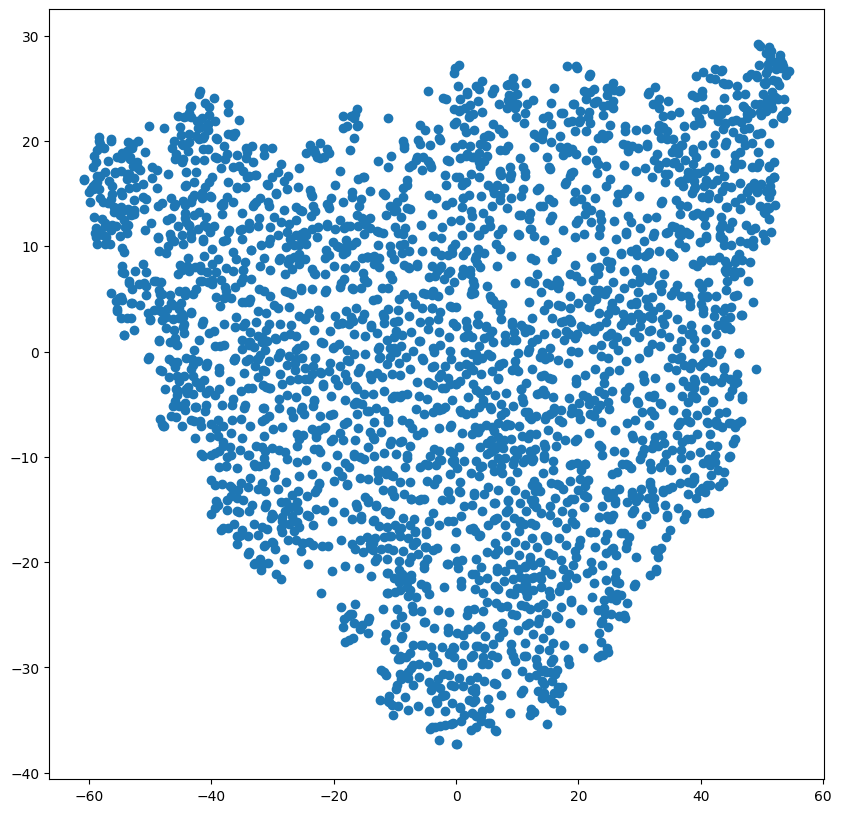

In [40]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0)
token_embeddings_tsne = tsne.fit_transform(token_embeddings)

plt.figure()
plt.scatter(token_embeddings_tsne[:, 0], token_embeddings_tsne[:, 1])
plt.show()

Veamos los vecinos más cercanos de un par de palabras. ¿En qué sentido son las similitudes?

In [59]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5)
nn.fit(token_embeddings)

test_words = ['awful','show']
idxs = [tokenizer.word_index[w] for w in test_words]
print(idxs)

distances, indices = nn.kneighbors(token_embeddings[idxs])
print(distances)
print(indices)
print([[tokenizer.index_word[idx] for idx in indices[k]] for k in [0,1]])

[282, 24]
[[7.30004830e-08 1.24647483e+00 1.25428467e+00 1.25724732e+00
  1.28645482e+00]
 [1.05367121e-08 6.11314670e-01 6.72547558e-01 6.78985343e-01
  6.81870408e-01]]
[[ 282 2239 2913 2444  622]
 [  24   13 1047 2720 2439]]
[['awful', 'asleep', 'miscast', 'unconvincing', 'dull'], ['show', 'make', 'ben', 'bride', 'clark']]


# ⭕ Ejercicio:

* Modifica la arquitectura de la LSTM para mejorar el desempeño de la LSTM anterior.
* Puedes usar también capas de dropout, callbacks, modificar las capas densas del final (recuerda que la capa final no se puede mover).